In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import scipy.stats

### EDA and Getting familiar with open CV

In [7]:
img=cv2.imread('Pandora_V1/Impressionism/gogh12300.jpg',1)
img2=cv2.imread('Pandora_V1/Surrealism/JoanMiro.jpg',1)


Using imshow() and OpenCV to display images

In [8]:
cv2.imshow('gogh12300',img)
cv2.imshow('Miro',img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

Using Matplotlib

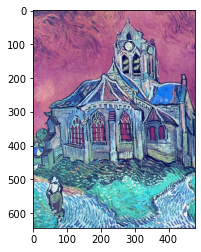

In [9]:
plt.imshow(img)
plt.show()

The image in matplotlib is displayed in RGB while open CV loads images in BGR. We need to restructure the image in order to get the right format.

In [10]:
#first lets see the shape of the image
print(img.shape)
img2.shape

(644, 478, 3)


(720, 555, 3)

In [11]:
b,g,r = cv2.split(img)

In [12]:
img_=cv2.merge([r,g,b])

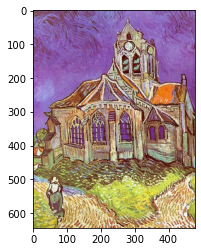

In [13]:
plt.imshow(img_)
plt.show()

we know have the image with the right colors

In [14]:
#trying to change from BGR to RGB with OpenCV
img2_=cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

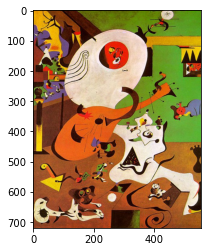

In [15]:
plt.imshow(img2_)
plt.show()

We have two methods to transform images from BGR to RGB.
We now need to resize de image so that all our images are the same size. We will do this with OpenCV

In [16]:
resimg = cv2.resize(img_, (16,16), interpolation = cv2.INTER_CUBIC)
resimg2 = cv2.resize(img2_, (16,16), interpolation = cv2.INTER_CUBIC)

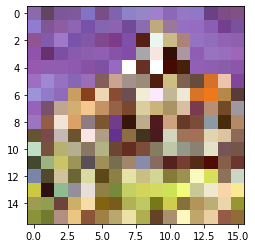

In [17]:
plt.imshow(resimg)
plt.show()

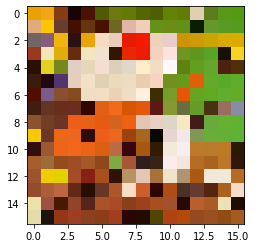

In [18]:
plt.imshow(resimg2)
plt.show()

In [19]:
# reshape of our images to get initial clusters.  
new_img = resimg.reshape((resimg.shape[0]*resimg.shape[1]),3)
new_img2 = resimg.reshape((resimg2.shape[0]*resimg2.shape[1]),3)

print(f'new size images: {new_img.shape} and {new_img2.shape}')

new size images: (256, 3) and (256, 3)


Exploring the orb local feature detector to to see if it is a good match to use in the analysis. ORB method could be useful to describe local features in the tiles and help us find the best image match.
Let us run ORB for both images

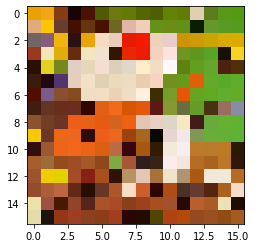

None


In [32]:
orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(resimg2,None)
# compute the descriptors with ORB
kp, des = orb.compute(resimg2, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(resimg2, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()
print(des)

It seems like ORB model does not detect any local features because the image resolution is too low. Let us try with the original size image.

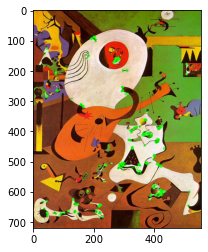

[[246 126 252 ... 245  14  31]
 [ 60 249 113 ...  15 116 231]
 [ 41  32 113 ... 138  66 172]
 ...
 [236 105 132 ...  57  82 130]
 [ 57 167 204 ... 216 208 120]
 [214  79 195 ... 243 167 229]]


In [36]:
orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(img2_,None)
# compute the descriptors with ORB
kp, des = orb.compute(img2_, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img2_, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()
print(des)

In [26]:
des.shape

(500, 32)

For the original size image the ORB detected local features and the descriptors array is of size (500,32). L:et us do the same analysis for the other image. 

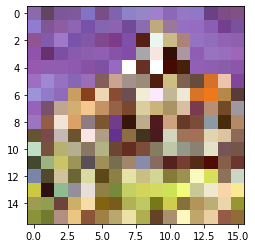

None


In [35]:
orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(resimg,None)
# compute the descriptors with ORB
kp, des = orb.compute(resimg, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(resimg, kp, None, color=(0,255,0), flags=0)
plt.imshow(resimg), plt.show()
print(des)

It looks like we have the same output for a low resolution image. The ORB model cannot get any features for this image size. 

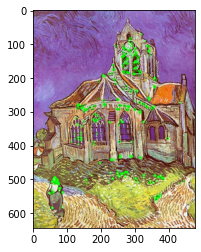

[[254  95 111 ...  87 244 127]
 [122  39 110 ... 230 126  75]
 [ 74  17  63 ... 135  37 123]
 ...
 [114 142  86 ...   6 106   6]
 [ 18  36  19 ...   8  49  40]
 [ 69 157  21 ... 105 192  49]]


In [40]:
orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(img_,None)
# compute the descriptors with ORB
kp, des = orb.compute(img_, kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img_, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()
print(des)

In [39]:
des.shape

(500, 32)

ORB is a very interesting model. It finds key point of interest to identify similar objects in other images. For our use case this method does not seem to be very appropriate because we are more interested in texture features not in local key point detection.

Let us know explore the Canny edge detection

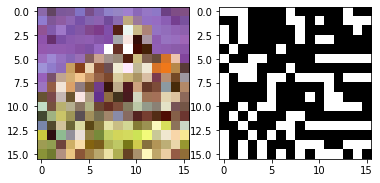

In [55]:
edges = cv2.Canny(resimg,100,200)
plt.subplot(1,2,1),plt.imshow(resimg,cmap = 'gray')
plt.subplot(1,2,2),plt.imshow(edges,cmap = 'gray')
plt.show()

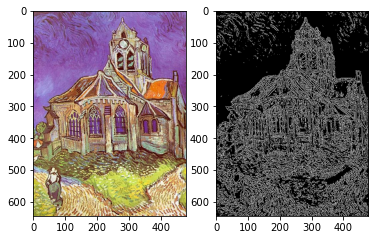

In [61]:
edges = cv2.Canny(img_,200,200)
plt.subplot(1,2,1),plt.imshow(img_,cmap = 'gray')
plt.subplot(1,2,2),plt.imshow(edges,cmap = 'gray')
plt.show()

The canny edges detection algorithm is very interesting and could be very useful if the size of the images that we where using was bigger.
ORB and Canny are interesting models but given that we are looking mainly texture features we will now focus on computing statistical texture features derived from the channel histograms.

First we will create a function to compute mean, variance and skewness. 

In [62]:
# definition of the mean
def statistics(image_size,color_scale,hist):
    #image size,color scale in this case from 0 to 255, h is the color histogram.
    
    # calculating the mean
    freq=0
    for n in color_scale:
        freq += (n*hist[n]) 
    mean = freq/image_size
    
    #getting the variance
    freq2=0
    for n in color_scale:
        freq2 += (n-mean)**2*hist[n]
    variance = freq2/image_size
    
    # definition of skewness
    #getting the standard deviation and mean
    sd = (variance)**(0.5)
    
    #getting skewness
    freq3=0
    for n in color_scale:
        freq3 += (n-mean)**3*hist[i]
    skew = freq3/(image_size*sd**3)

    return mean, variance, skew

We will now compute the feature array and we will display the three channel histogram. 

[155.69531]
[2133.6104]
[0.]
[126.96094]
[3284.6091]
[0.]
[124.79297]
[3551.7107]
[0.]


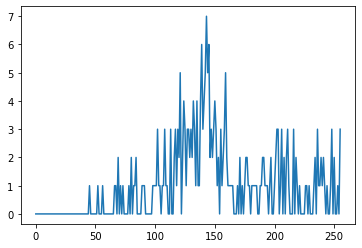

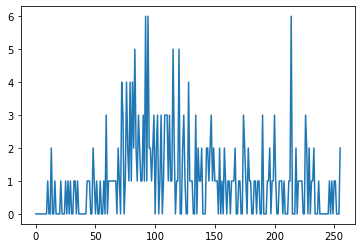

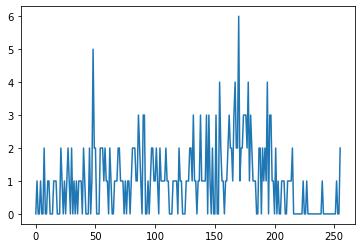

In [64]:
KM_features = []    
for i in range(0,3):
    hist = cv2.calcHist([resimg],[i],None,[256],[0,256])
    #getting the mean, variance and skewness
    stats = statistics(256, range(0,256), hist)
    mean = stats[0]
    variance = stats[1]
    skew = stats[2]
    KM_features.append(mean)
    KM_features.append(variance)
    KM_features.append(skew)
    print(mean)
    print(variance)
    print(skew)
    plt.figure()
    plt.plot(hist)
    plt.show